In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

In [ ]:
# Merge features and demographics together

# Load two files
features_df = pd.read_csv("../features/all_features_merged.csv")
demographic_df = pd.read_excel("../participant_demographics_table.xlsx")

# Clean demographic DataFrame
# Standardization the column name
demographic_df.columns = demographic_df.columns.str.strip().str.replace(" ", "_").str.lower()
# Extract subject number from ID
demographic_df["subject"] = demographic_df["trial_id"].str.extract(r"T(\d+)").astype(int)

# Merge using features_df['Subject'] and demographic_df['subject']
merged_df = features_df.merge(demographic_df, left_on="Subject", right_on="subject", how="left")

# Save to new file
merged_df.to_csv("../features/features_with_demo.csv", index=False)


In [3]:
merged_df.head()  

,ankle_Acc_X_mean,ankle_Acc_X_std,ankle_Acc_X_skew,ankle_Acc_X_kurt,ankle_Acc_X_iqr,ankle_Acc_X_sma,ankle_Acc_X_spe,ankle_Acc_X_ppf,ankle_Acc_Y_mean,ankle_Acc_Y_std,...,dominant_side,age,height_(cm),weight_(kg),most_affected_side,hoehn_and_yahr_(stage),years_since_diagnosis,cit,updrs,subject
0,1.574001,1.229563,-3.942524,26.178878,0.018981,1.814221,2.706374,0.8,9.682674,0.748520,...,R,70,183,92,Right,Three,6,4,71,11
1,1.076608,2.317051,-2.650290,7.476643,1.093011,2.057104,3.576606,0.8,9.691851,1.885551,...,R,70,183,92,Right,Three,6,4,71,11
2,0.695348,3.603414,-1.472929,9.654722,1.943030,2.274548,3.418213,1.0,10.084883,1.963305,...,R,70,183,92,Right,Three,6,4,71,11
3,1.368532,6.003468,0.615921,5.839792,2.282835,3.419414,3.037735,0.8,10.670244,2.682854,...,R,70,183,92,Right,Three,6,4,71,11
4,1.792980,6.448243,0.482381,3.610016,2.744634,4.223076,3.496999,0.6,11.018744,3.578314,...,R,70,183,92,Right,Three,6,4,71,11


---

#### Hoehn and Yahr Stage  
- stage four only have one paient.
- "stratify", each category should have at leat two sample.


#### Gender
Use `Stratify` to keep the distribution of a variable proportionally in the training, validation, and test sets to prevent sample skewing.  

- Total 21 subjects, 8 feamle, 13 male.
- Set train dataset 60%, validation 20% and test 20%.
- If 70:15:15 --- too few female

In [ ]:
# Load the merged features file
df = pd.read_csv("../features/features_with_demo.csv")

# Calculate number of Activity completed by each Subject.
activity_counts = df.groupby("Subject")["Activity"].nunique().reset_index()
activity_counts.columns = ["Subject", "NumActivities"]

# Only keep the Subject who has complete all 12 activities.
full_activity_subjects = activity_counts[activity_counts["NumActivities"] == 12]["Subject"].tolist()



In [ ]:
print(f"There were {len(full_activity_subjects)} participants who completed all 12 activities")
print("Subject ID:", full_activity_subjects)

There were 13 participants who completed all 12 activities
Subject ID: [1, 2, 3, 4, 5, 11, 12, 13, 14, 17, 18, 19, 25]


In [5]:
# Table show all participants and the activities they completed
activity_counts

,Subject,NumActivities
0,1,12
1,2,12
2,3,12
3,4,12
4,5,12
5,11,12
6,12,12
7,13,12
8,14,12
9,17,12


In [ ]:

# Find subjects who completed all 12 activities
activity_counts = df.groupby("Subject")["Activity"].nunique().reset_index()
full_subjects = activity_counts[activity_counts["Activity"] == 12]["Subject"].tolist()

# Get gender info for each subject
subject_gender = df.groupby("Subject")["sex"].first().reset_index()

# Prioritise test set from full-activity group
full_df = subject_gender[subject_gender["Subject"].isin(full_subjects)]

# Calculate the number of subjects required for the test set -> 20% of total subjects
n_test = round(subject_gender["Subject"].nunique() * 0.2)


# Stratified selection from full_subjects
test_subjects, _ = train_test_split(
    full_df, test_size=len(full_df) - n_test, stratify=full_df["sex"], random_state=42
)


# Get the subjects of Non-Test Set
remaining = subject_gender[~subject_gender["Subject"].isin(test_subjects["Subject"])]

# Split remaining subjects into train and val (60% and 20%)
train_subjects, val_subjects = train_test_split(
    remaining, test_size=0.25, stratify=remaining["sex"], random_state=42
)


# Mark split in dataframe
# Add a new column in the dataframe
df["set"] = "train" 
# Mark the 'set' column as 'val/test'
df.loc[df["Subject"].isin(val_subjects["Subject"]), "set"] = "val"
df.loc[df["Subject"].isin(test_subjects["Subject"]), "set"] = "test"

# Save split version of merged dataframe
# df.to_csv("../gender/features_with_demo_split_new.csv", index=False) # stage four in train
df.to_csv("../gender/features_with_demo_split.csv", index=False)

os.makedirs("../gender", exist_ok=True)
train_df = df[df["set"] == "train"]
val_df = df[df["set"] == "val"]
test_df = df[df["set"] == "test"]

# save train/test/val into csv files
train_df.to_csv("../gender/train.csv", index=False)
val_df.to_csv("../gender/val.csv", index=False)
test_df.to_csv("../gender/test.csv", index=False)


#  Count the number of subjects in each test/val/train and gender
summary = df.groupby(["set", "sex"])["Subject"].nunique().unstack(fill_value=0)
summary["Total_Subjects"] = summary.sum(axis=1)
split_summary_df = summary.reset_index()



In [7]:
summary

sex,F,M,Total_Subjects
set,,,
test,2,2,4
train,4,8,12
val,2,3,5


In [24]:
# train set
print("=== Train Set Summary ===")
print(f"Total Subjects: {train_subjects.shape[0]}")
print("Subject IDs:", train_subjects['Subject'].tolist())
print(train_subjects['sex'].value_counts())
print("-----")


# validation set
print("=== Validation Set Summary ===")
print(f"Total Subjects: {val_subjects.shape[0]}")
print("Subject IDs:", val_subjects['Subject'].tolist())
print(val_subjects['sex'].value_counts())
print("-----")


# test set
print("=== Test Set Summary ===")
print(f"Total Subjects: {test_subjects.shape[0]}")
print("Subject IDs:", test_subjects['Subject'].tolist())
print(test_subjects['sex'].value_counts())


=== Train Set Summary ===
Total Subjects: 12
Subject IDs: [29, 28, 24, 21, 3, 26, 14, 25, 12, 18, 5, 11]
sex
M    8
F    4
Name: count, dtype: int64
-----
=== Validation Set Summary ===
Total Subjects: 5
Subject IDs: [17, 13, 22, 23, 20]
sex
M    3
F    2
Name: count, dtype: int64
-----
=== Test Set Summary ===
Total Subjects: 4
Subject IDs: [4, 2, 1, 19]
sex
M    2
F    2
Name: count, dtype: int64


Hoehn & Yahr stage distribution:
hoehn_and_yahr_(stage)  Four  One  Three  Two
set                                          
test                       0    0      1    3
train                      0    2      5    5
val                        1    1      2    1


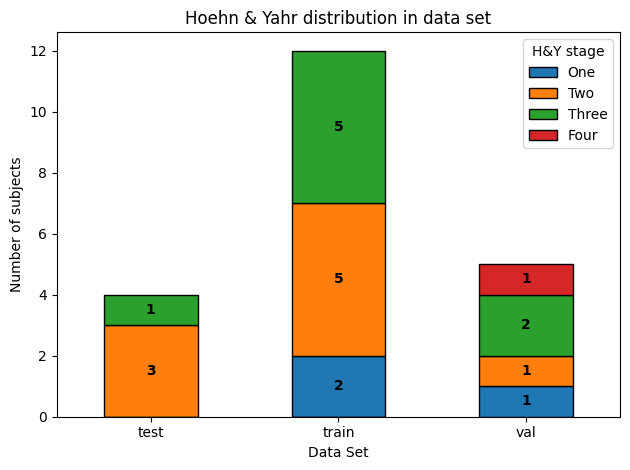

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../gender/features_with_demo_split.csv") 

# Get the Hoehn & Yahr stage from each subject
subject_stages = df.groupby(['Subject', 'set'])['hoehn_and_yahr_(stage)'].first().reset_index()

# Count the number of stages from each dataset
stage_distribution = subject_stages.groupby(['set', 'hoehn_and_yahr_(stage)']).size().unstack(fill_value=0)

# Print the results
print("Hoehn & Yahr stage distribution:")
print(stage_distribution)


desired_order = ['One', 'Two', 'Three', 'Four']
stage_distribution = stage_distribution[desired_order]

# Plot
stage_distribution.plot(kind='bar', stacked=True, edgecolor='black')

plt.title('Hoehn & Yahr distribution in data set')  
plt.xlabel('Data Set')  
plt.ylabel('Number of subjects')  
plt.xticks(rotation=0)  
plt.legend(title='H&Y stage')  

# Add label, counts
for i, (idx, row) in enumerate(stage_distribution.iterrows()):
    cumulative = 0
    for stage in stage_distribution.columns:
        count = row[stage]
        if count > 0:
            plt.text(i, cumulative + count / 2, str(count),
                     ha='center', va='center', fontsize=10,
                     color='black', fontweight='bold')
        cumulative += count

plt.tight_layout()
plt.show()


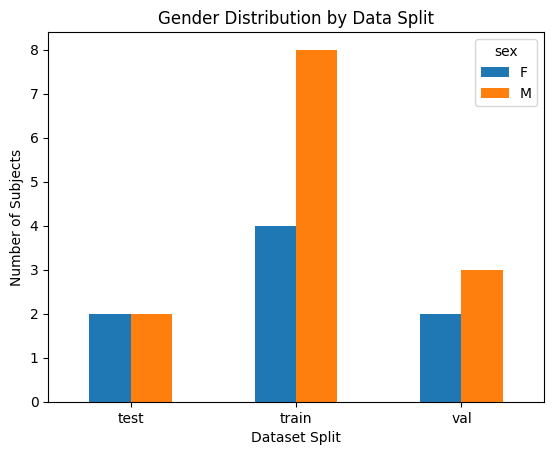

In [ ]:
import matplotlib.pyplot as plt

# Group by set and sex, count subjects
summary_plot = df.groupby(["set", "sex"])["Subject"].nunique().unstack().fillna(0)

# Plot
summary_plot.plot(kind="bar", stacked=False)
plt.title("Gender Distribution by Data Split")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Subjects")
plt.xticks(rotation=0)
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv("../gender/features_with_demo_split.csv") 

# Get the Hoehn & Yahr stage from each subject
subject_stages = df.groupby(['Subject', 'set'])['hoehn_and_yahr_(stage)'].first().reset_index()

# Count the number of stages from each dataset
stage_distribution = subject_stages.groupby(['set', 'hoehn_and_yahr_(stage)']).size().unstack(fill_value=0)

# Print the results
print("Hoehn & Yahr stage distribution:")
print(stage_distribution)


Hoehn & Yahr stage distribution:
hoehn_and_yahr_(stage)  Four  One  Three  Two
set                                          
test                       0    0      1    3
train                      0    2      5    5
val                        1    1      2    1
